## Robust CNN modelling

This notebook is a solution to solve overfitting in a CNN model using pytorch framework, not just by tweaking a parameter, but by systematically re-engineering the entire machine learning pipeline with a suite of pytorch tools and techniques.

To accomplish this, we will deploy a multi-faceted strategy, upgrading every component of the setup:

* **Enhance the Data Pipeline** with more powerful data augmentation to create a richer training set.

* **Refactor the Architecture for Modularity**, creating reusable `CNNBlocks` for cleaner, more scalable code.

* **Integrate Advanced Layers** like **Batch Normalization** to stabilize training and improve generalization.

* **Deploy a Robust Regularization Strategy** using **Dropout** and **Weight Decay** to combat overfitting directly.

In [28]:
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

In [2]:
import helper_utils

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using [device: {device}] for torch")

Using [device: cuda] for torch


## Data Pipeline 

The task is to define two distinct image transformation pipelines using `torchvision.transforms`.

**Task**:

* **For `train_transformations`**: Create a composition of transforms for the training dataset.
* **For `val_transformations`**: Create a second, simpler pipeline for the validation dataset.

In [17]:
def create_transforms(mean, std):
    """
    Create image transformation pipeline for training and validation
    """

    train_transforms = transforms.Compose([
                            transforms.RandomHorizontalFlip(p=0.5),
                            transforms.RandomVerticalFlip(p=0.5),
                            transforms.RandomRotation(degrees = 15),
                            transforms.ToTensor(),
                            transforms.Normalize(mean = mean, std = std)
    ])

    val_transforms = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(mean = mean, std = std)
    ])

    return train_transforms,val_transforms

    

In [22]:
cifar100_mean =  (0.5071, 0.4867, 0.4408) #cifar100 dataset mean
cifar100_std = (0.2675, 0.2565, 0.2761)  #cifar100 dataset std

In [23]:
print("--- Verifying define_transformations ---\n")
train_transform, val_transform = create_transforms(cifar100_mean, cifar100_std)

print("Training Transformations:")
print(train_transform)
print("-" * 30)
print("\nValidation Transformations:")
print(val_transform)

--- Verifying define_transformations ---

Training Transformations:
Compose(
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761))
)
------------------------------

Validation Transformations:
Compose(
    ToTensor()
    Normalize(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761))
)


In [24]:
# Define the full class list.
all_target_classes = [
    # Flowers
    'orchid', 'poppy', 'rose', 'sunflower', 'tulip',
    # Mammals
    'fox', 'porcupine', 'possum', 'raccoon', 'skunk',
    # Insects
    'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'
]

In [ ]:
# Load the full datasets an filter for the above 15
train_dataset, val_dataset = helper_utils.load_cifar100_subset(all_target_classes, train_transform, val_transform)

Dataset not found in './cifar_100'. Downloading...


100%|██████████| 169M/169M [00:22<00:00, 7.38MB/s] 


Extracting ./cifar_100\cifar-100-python.tar.gz to ./cifar_100
Files already downloaded and verified
Dataset loaded successfully.

Filtering for 15 classes...
Filtering complete. Returning training and validation datasets.


In [42]:
#create train and val dataloader

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size= batch_size, shuffle = False)


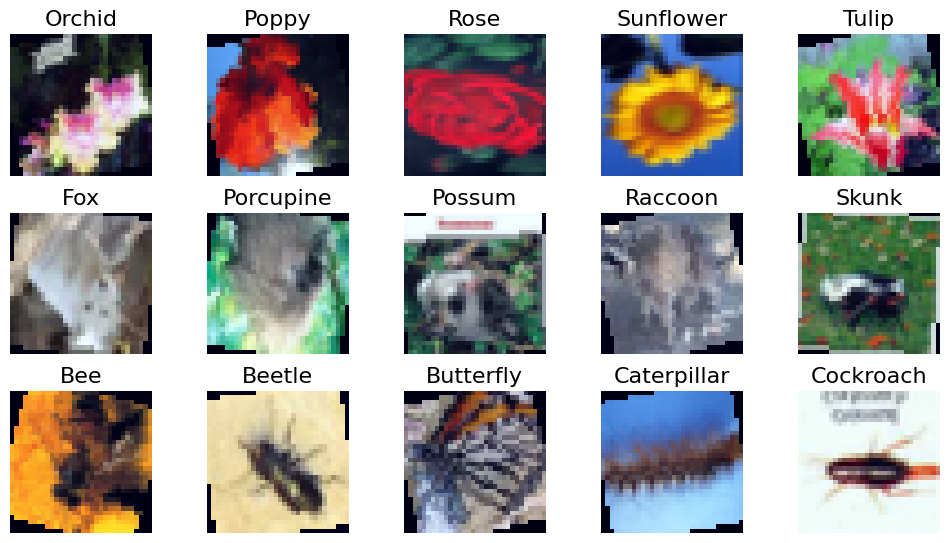

In [27]:
## Visualise the Training images
# Visualize a grid of random training images
helper_utils.visualise_images(train_loader, grid=(3, 5))

## 2 - Building a Modular and Robust CNN

With a more robust data pipeline in place, your next step is to enhance the model's architecture itself. We refactor the original CNN to be more modular, efficient, and powerful. This is the next pivotal step toward resolving the overfitting problem and pushing model's performance to new heights.

### 2.1 - The Power of Modularity: The CNNBlock
A much better approach is to group these patterns into a single, reusable module. The first task is to create a `CNNBlock` that packages these layers together. This modular design makes the model's code significantly cleaner and easier to manage.

#### 2.1.1 - <code>[BatchNorm2d Layer](https://docs.pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)</code>

As part of this new, improved block, we will also introduce a powerful new layer: `BatchNorm2d`. This layer is a pivotal technique for building modern, high performing deep neural networks.

Think of Batch Normalization as a traffic controller for the data flowing between your network's layers. After a convolutional layer processes a batch of images, the outputs (or activations) can have widely varying distributions from one batch to the next. `BatchNorm2d` steps in and normalizes these activations within each mini batch, adjusting them to have a consistent mean and standard deviation. It then uses two learnable parameters to scale and shift this normalized output, allowing the network itself to learn the optimal distribution for the data at that point.

This seemingly simple step provides three profound benefits:

* **It Stabilizes and Accelerates Training**: By keeping the distribution of data consistent between layers, it prevents later layers from having to constantly adapt to a shifting input from the layers before them. This stability allows us to use higher learning rates, which can dramatically speed up how quickly the model learns.

* **It Acts as a Regularizer**: Because the normalization statistics are calculated for each unique mini batch, it introduces a slight amount of noise into the training process. This noise makes it harder for the model to perfectly memorize the training data, encouraging it to learn more general features and thus reducing overfitting.

* **It Reduces Sensitivity to Initialization**: The layer makes the model less dependent on the specific random weights it starts with, leading to more reliable and repeatable training results.

By adding `BatchNorm2d` to your `CNNBlock`, we are not just adding another layer; we are also fundamentally making the model's training process more stable, efficient, and robust.

In [31]:
#create a reusable cnn block

class CNNBlock(nn.Module):
    """
    Defines a single convolutional block for CNN
    """

    def __init__(self, in_channels, out_channels, kernel_size =3, padding=1):
        """
        Initializes the layers of CNN block
        """

        super().__init__()

        self.block = nn.Sequential(
                        nn.Conv2d(in_channels=in_channels, out_channels=out_channels,kernel_size=kernel_size, padding=padding),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size = 2, stride = 2)                        
        )

    
    def forward(self, x):
        
        return self.block(x)



In [32]:
# Verify the CNNBlock
print("--- Verifying CNNBlock ---\n")

# Instantiate the block with 3 input channels and 16 output channels
verify_cnn_block = CNNBlock(in_channels=3, out_channels=16)
print("Block Structure:\n")
print(verify_cnn_block)

# Verify the output shape after a forward pass
# Create a dummy input tensor (batch_size=1, channels=3, height=32, width=32)
dummy_input = torch.randn(1, 3, 32, 32)
print(f"\nInput tensor shape:  {dummy_input.shape}")

# Pass the dummy tensor through the block
output = verify_cnn_block(dummy_input)
print(f"Output tensor shape: {output.shape}")

--- Verifying CNNBlock ---

Block Structure:

CNNBlock(
  (block): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)

Input tensor shape:  torch.Size([1, 3, 32, 32])
Output tensor shape: torch.Size([1, 16, 16, 16])


### 2.2 - Assembling the Full CNN with Modular Blocks
Now that we have a reusable `CNNBlock`, we can assemble the full `SimpleCNN` architecture. By using this new modular block, we will have a much cleaner and more professional model definition. Instead of defining many individual layers for the convolutional part of the network, we will now define just three `CNNBlock` instances.

Thge model will consist of two main parts:

* **A feature extractor**: A sequence of three CNNBlocks that will learn to identify visual patterns in the images.
* **A classifier**: A sequence of fully connected layers that will take the features from the convolutional blocks and make the final prediction.

In this new version, we will also increase the **dropout rate to `0.6`**. This is another important step against overfitting, as it makes the model less likely to rely on any single feature.

In [35]:
class CNNModel(nn.Module):
    """
    Defines a CNN architecture using modular CNN blocks
    This model stacks 3 usable cnn blocks followed by fully connected classifier
    to perform image classification
    """

    def __init__(self, num_classes):
        """
        Initialize the layers of CNN model
        """

        super().__init__()

        self.conv_block1 = CNNBlock(3,32)
        self.conv_block2 = CNNBlock(32,64)
        self.conv_block3 = CNNBlock(64,128)


        self.features = nn.Sequential(
                            self.conv_block1, 
                            self.conv_block2, 
                            self.conv_block3
                            )

        self.classifier = nn.Sequential(
                            nn.Flatten(start_dim=1),
                            nn.Linear(128*4*4, 512),
                            nn.ReLU(),
                            nn.Dropout(0.6),
                            nn.Linear(512, num_classes)
                            )
        
        
    def forward(self, x):
        """
        Forward propagation flow
        """
        x= self.features(x)
        return self.classifier(x)

In [36]:
# Verify the SimpleCNN
print("--- Verifying SimpleCNN ---\n")

# Verify the structure of the model
# Instantiate the model with 15 output classes
verify_simple_cnn = CNNModel(num_classes=15)
print("Model Structure:\n")
print(verify_simple_cnn)

# Verify the output shape after a forward pass
# Create a dummy input tensor (batch_size=64, channels=3, height=32, width=32)
dummy_input = torch.randn(64, 3, 32, 32)
print(f"\nInput tensor shape:  {dummy_input.shape}")

# Pass the dummy tensor through the model
output = verify_simple_cnn(dummy_input)
print(f"Output tensor shape: {output.shape}")

--- Verifying SimpleCNN ---

Model Structure:

CNNModel(
  (conv_block1): CNNBlock(
    (block): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (conv_block2): CNNBlock(
    (block): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (conv_block3): CNNBlock(
    (block): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, 

In [37]:
# Get the number of classes
num_classes = len(train_dataset.classes)

# Instantiate the model
model = CNNModel(num_classes)

## 3 - Training the Upgraded Model
With the upgraded data pipeline and modular CNN architecture complete, we are ready to begin the training process. Configure the final pieces of the training pipeline: the loss function and the optimizer. Then, we will implement the core training and validation logic that will run the experiment and reveal how well the new model performs.

### 3.1 - Configuring the Loss and Optimizer

Before we can train the model, yweou must define two key components: a loss function to measure error and an optimizer to update the model's weights.

* For the loss function, continue to use `nn.CrossEntropyLoss`, the standard choice for multi-class classification.
>
* For the optimizer, use `Adam`, but with an important addition to combat overfitting: `weight_decay`. 
    * Weight decay adds a penalty to the loss function based on the magnitude of the model's weights. It encourages the network to learn smaller, simpler weight values, which makes it more robust and less likely to memorize the training data. This is another vital tool for improving the model's ability to generalize.

In [38]:
loss_function = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.0005)

### 3.2 - Implementing the Training and Validation Logic

Implement the core logic for training and evaluating the model. This will be done in two separate functions:

* `train_epoch`: To perform a single pass over the training data to update the model.
* `validate_epoch`: To perform a single pass over the validation data to measure performance.


In [40]:
def train_epoch(model, train_loader, loss_function, optimizer, device):
    """
    Performs single epoch of training
    """

    model.train()
    running_loss = 0.0

    for images,labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()*images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    return epoch_loss

In [41]:
# Use a helper function to perform a sanity check on the train_epoch implementation
helper_utils.verify_training_process(CNNModel, train_loader, loss_function, train_epoch, device)

--- Verifying train_epoch (training for 5 epochs) ---

Training on 320 images for 5 epochs:

Epoch [1/5], Loss: 2.7688
Epoch [2/5], Loss: 2.4708
Epoch [3/5], Loss: 2.0225
Epoch [4/5], Loss: 1.8124
Epoch [5/5], Loss: 1.7228

Weight Update Check:	Model weights changed during training.
Loss Trend Check:	Loss decreased from 2.7688 to 1.7228.


In [45]:
def validate_epoch(model, val_loader, loss_function, device):
    """
    Performs a single validation epoch       
    """

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():

        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)

            running_loss += loss.item()

            _, predicted = torch.max(outputs, dim=1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_val_loss = running_loss / len(val_loader.dataset)
    epoch_val_accuracy = correct / total *100

    return epoch_val_accuracy, epoch_val_loss

In [46]:
# Use a helper function to perform a sanity check on the validate_epoch implementation
helper_utils.verify_validation_process(CNNModel, val_loader, loss_function, validate_epoch, device)

--- Verifying validate_epoch ---

Validating on 320 images:

Returned Validation Loss: 9.3750
Returned Validation Accuracy: 0.08%


Return Types Check:	Function returned a float for loss and accuracy.
Weight Integrity Check:	Model weights were not changed during validation.


In [52]:
def training_loop(model, train_loader, val_loader, loss_function, optimizer, num_epochs, device):
    """
    Trains and Validates a PyTorch Neural Network model    
    """

    model.to(device)

    best_val_acc = 0
    best_model_state = None
    best_epoch = 0

    training_losses, val_losses, val_accuracies = [],[],[]

    print("--- Training Started ---")

    for epoch in range(num_epochs):
        epoch_loss = train_epoch(model, train_loader, loss_function, optimizer, device)
        training_losses.append(epoch_loss)

        epoch_accuracy, epoch_val_loss = validate_epoch(model, val_loader, loss_function, device)
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_accuracy)

        print(f"-- Epoch [{epoch+1} / {num_epochs}] | Train Loss : {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_accuracy:.2f}%")
        

        if epoch_accuracy > best_val_acc:
            best_val_acc = epoch_accuracy

            best_epoch = epoch + 1

            best_model_state = copy.deepcopy(model.state_dict())

    print("-- Training Completed") 

    if best_model_state:
        print(f" -- Returning best model with \n Accuracy (Val) {best_val_acc:2f} at epoch: {best_epoch} --")
        model.load_state_dict(best_model_state)

    metrics = [training_losses, val_losses, val_accuracies]

    return model, metrics




--- Training Started ---
-- Epoch [1 / 50] | Train Loss : 2.1656, Val Loss: 0.0562, Val Accuracy: 38.13%
-- Epoch [2 / 50] | Train Loss : 1.8544, Val Loss: 0.0509, Val Accuracy: 43.67%
-- Epoch [3 / 50] | Train Loss : 1.7470, Val Loss: 0.0467, Val Accuracy: 47.73%
-- Epoch [4 / 50] | Train Loss : 1.6649, Val Loss: 0.0460, Val Accuracy: 50.13%
-- Epoch [5 / 50] | Train Loss : 1.6168, Val Loss: 0.0459, Val Accuracy: 49.73%
-- Epoch [6 / 50] | Train Loss : 1.5599, Val Loss: 0.0440, Val Accuracy: 52.53%
-- Epoch [7 / 50] | Train Loss : 1.5111, Val Loss: 0.0411, Val Accuracy: 56.60%
-- Epoch [8 / 50] | Train Loss : 1.4596, Val Loss: 0.0398, Val Accuracy: 57.60%
-- Epoch [9 / 50] | Train Loss : 1.4429, Val Loss: 0.0388, Val Accuracy: 58.53%
-- Epoch [10 / 50] | Train Loss : 1.4032, Val Loss: 0.0404, Val Accuracy: 56.20%
-- Epoch [11 / 50] | Train Loss : 1.3702, Val Loss: 0.0400, Val Accuracy: 57.27%
-- Epoch [12 / 50] | Train Loss : 1.3493, Val Loss: 0.0396, Val Accuracy: 59.13%
-- Epoch [13

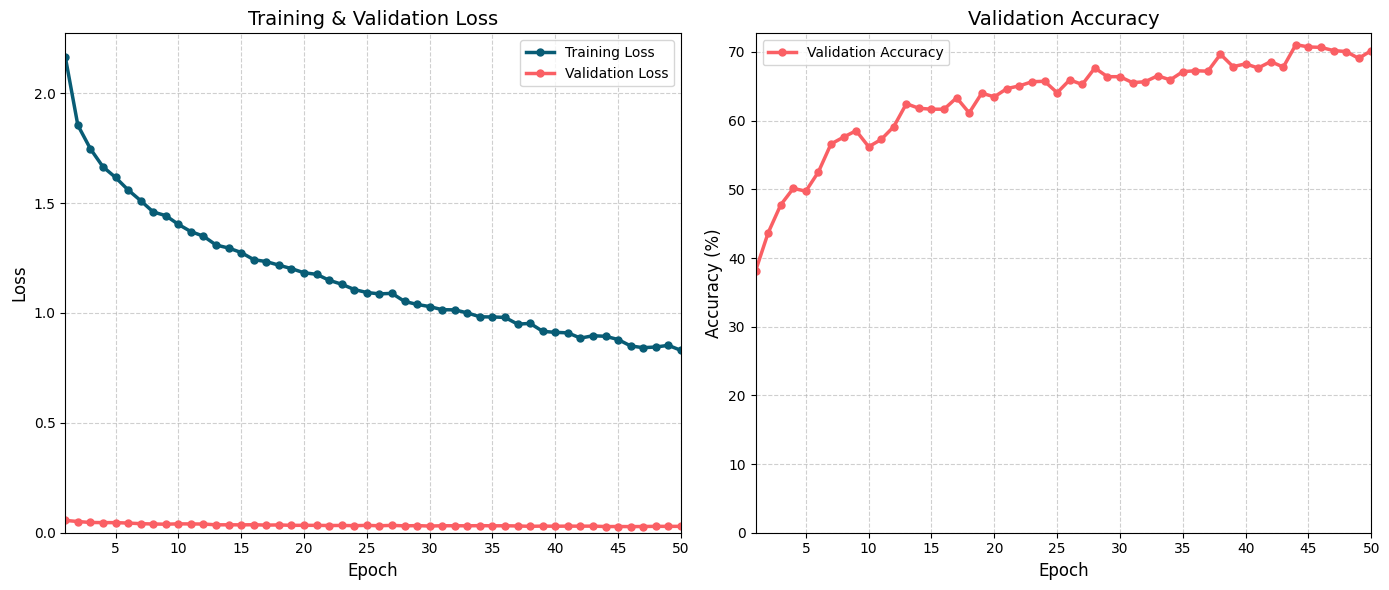

In [53]:
# Start the training process by calling the training loop function
trained_model, training_metrics = training_loop(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    loss_function=loss_function, 
    optimizer=optimizer, 
    num_epochs=50, 
    device=device
)

# Visualize the training metrics (loss and accuracy)
print("\n--- Training Plots ---\n")
helper_utils.plot_training_metrics(training_metrics)